In [1]:
cd ..

/mnt/home/ahern/projects/rf_diffusion


In [2]:
%load_ext autoreload
%autoreload 2

import glob
import os
import sys
from itertools import *
from collections import defaultdict
import torch
import re
from inference import utils as iu
import diffusion
import hydra
from hydra import compose, initialize
from inference import model_runners
import util
from icecream import ic
import matplotlib.pyplot as plt
import tqdm
import estimate_likelihood as el
from dataclasses import astuple
import pickle
import seaborn as sns
import pandas as pd

[18:11:11] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /home/ahern/.conda/envs/woody-SE3-nvidia/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.10.1.so: cannot open shared object file: No such file or directory
Using backend: pytorch


In [3]:
def get_rf_df(pickle_dir):

    pickle_dirs = sorted(glob.glob(os.path.join(pickle_dir, '*')))
    last_pickle_dir = pickle_dirs[-1]
    pickles = sorted(glob.glob(os.path.join(last_pickle_dir, '*')))

    len(pickles)

    args_arr = []
    for p in tqdm.tqdm(pickles):
        with open(p, 'rb') as fh:
            args_arr.append(pickle.load(fh))



    df = pd.DataFrame(args_arr)
    df.t = df.t.apply(lambda x: x.item())

    return df

In [4]:
def filter_training(df):
    df['stack_str'] = df.apply(lambda r: '\n'.join(r.stack[-3:]), axis=1)

    # for i in df['stack'][:1]:
    #     print('\n'.join(i[:3]))
    #     print('------------------------')

    # callsite_counts = df.stack_str.value_counts()
    # most_called=sorted(dict(callsite_counts).items(), key= lambda i: i[1])[-1]
    # most_called_callsite=most_called[0]

    def in_train_cycle(stack):
        for frame in stack[::-1]:
            if 'train_cycle' in frame:
                return True
        return False

    return df[df['stack'].apply(in_train_cycle)]

In [5]:
def filter_i_cycle(df, i_cycle):
    return df[df.i_cycle == 0]

In [7]:
df_infer = get_rf_df('/home/ahern/projects/rf_diffusion/pickled_inputs/inference')
len(df_infer)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 408.95it/s]


4000

In [9]:
df_train = get_rf_df('/home/ahern/projects/rf_diffusion/pickled_inputs/training')
df_train = filter_training(df_train)
df_train = filter_i_cycle(df_train, 0)
len(df_train)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1675/1675 [00:07<00:00, 224.09it/s]


661

In [10]:
df_infer['source'] = 'inference'
df_train['source'] = 'training'
df = df_infer.append(df_train, ignore_index=True)

In [11]:
len(df)

4661

In [12]:
def fraction_sequence_masked(row):
    _, L, _ = row.seq.shape
    return (row.seq[0,:,21].sum() / L).item()

In [13]:
def compute_distribution(df, metric, over='t', metric_name=None):
    #apply_kwargs = apply_kwargs or {}
    metric_name = metric_name or metric.__name__
    df[metric_name] = df.apply(metric, axis=1)
    # df[metric_name] = df[fraction_sequence_masked.__name__].apply(lambda x: x.item())
    # overs = df[over]
    # return overs, vals

In [14]:
def compare(df, metric):
    compute_distribution(df, metric)
    sns.relplot(data=df, x='t', hue='source', y=metric.__name__, kind="line")

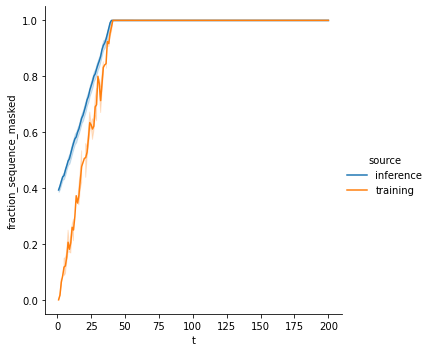

In [15]:
compare(df, fraction_sequence_masked)

In [16]:
def template_confidence(row):
    return row.t1d[0,0,:,21].mean().item()

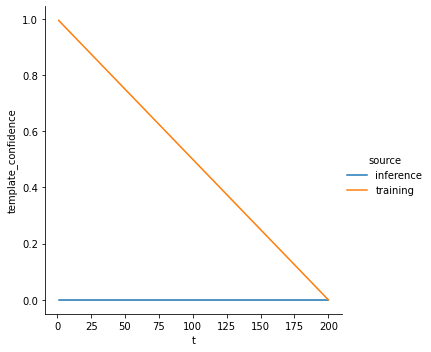

In [17]:
compare(df, template_confidence)

In [18]:
def xyz_xyz_t_match(row):
    return (row.xyz[0,:,:3] == row.xyz_t[0,0,:,:3]).float().mean().item()

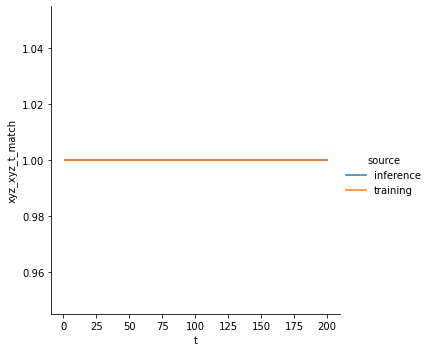

In [19]:
compare(df, xyz_xyz_t_match)

In [20]:
example_row = df.iloc[0]

In [21]:
example_train_row = df_train.iloc[0]